# Base Model

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
# os.chdir('/home/bcasares/cs231n_project')
os.chdir('/Users/bcasares/git_folders/cs231n/cs231n_project/')


In [17]:
import torch
import torch.optim as optim
import torch.nn.functional as F  # useful stateless functions
import numpy as np

In [4]:
import utils
import json

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt


In [5]:
json_path = os.path.join("experiments/base_model", 'params.json')
params = utils.Params(json_path)

In [9]:
params.cuda = torch.cuda.is_available()

In [10]:
from model.data_loader import fetch_dataloader

In [11]:
# loader_train = fetch_dataloader("train", "data/HOUSES_SPLIT", "data/HOUSES_SATELLITE_SPLIT", params)["train"]
# loader_val = fetch_dataloader("val", "data/HOUSES_SPLIT", "data/HOUSES_SATELLITE_SPLIT", params)["val"]
# loader_test = fetch_dataloader("test", "data/HOUSES_SPLIT", "data/HOUSES_SATELLITE_SPLIT", params)["test"]


loader_train = fetch_dataloader("train", ["data/HOUSES_SPLIT_SMALL", "data/HOUSES_SATELLITE_SPLIT_SMALL"], params)["train"]
loader_val = fetch_dataloader("val", ["data/HOUSES_SPLIT_SMALL", "data/HOUSES_SATELLITE_SPLIT_SMALL"], params)["val"]
loader_test = fetch_dataloader("test", ["data/HOUSES_SPLIT_SMALL", "data/HOUSES_SATELLITE_SPLIT_SMALL"], params)["test"]


In [12]:
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)

using device: cpu


In [18]:
def check_accuracy_part34(loader, model):
    if loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')   
    rmse_sum = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for X, y in loader:
            x, x2, x3 = X
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            x2 = x2.to(device=device, dtype=dtype)
            x3 = x3.to(device=device, dtype=dtype)
            
            y = y.to(device=device, dtype=torch.float)
            join_x = (x,x2,x3)
            scores = model(join_x)
            preds = scores
            rmse_sum += ((preds - y)**2).sum()
            num_samples += preds.size(0)
        rmse = np.sqrt(float(rmse_sum)) / num_samples
        print("The RMSE is {}".format(rmse))
        return rmse

In [19]:
def train_part34(model, optimizer, epochs=1):
    """
    Train a model on using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    losses = []
    for e in range(epochs):
        for t, (X, y) in enumerate(loader_train):
            x, x2, x3 = X
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            x2 = x2.to(device=device, dtype=dtype)
            x3 = x3.to(device=device, dtype=dtype)
            y = y.to(device=device, dtype=torch.float)
            join_x = (x, x2, x3)
            scores = model(join_x)
            loss = F.smooth_l1_loss(scores, y)
            losses.append(loss.item())

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            if t % print_every == 0:
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                check_accuracy_part34(loader_val, model)
                print()
                
    return losses 

In [20]:
from model.net import Net as ThreeLayerConvNet

In [21]:
# learning_rates = [1e-2, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9]
# learning_rates = [1e-2, 2.5e-2, 5e-2, 7.5e-2,  
#                   1e-3, 2.5e-3, 5e-3, 7.5e-3,
#                   1e-4, 2.5e-4, 5e-4, 7.5e-4,
#                   1e-5, 2.5e-5, 5e-5, 7.5e-5,] 
learning_rates = [1e-3] 
model = ThreeLayerConvNet(params)
losses_model = []
for learning_rate in learning_rates:
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    losses = train_part34(model, optimizer, epochs=10)
    losses_model.append(losses)



Iteration 0, loss = 13.3508
Checking accuracy on test set
The RMSE is 3.328524953960932

Iteration 0, loss = 9.5115
Checking accuracy on test set
The RMSE is 6.6522629637637225

Iteration 0, loss = 2.7225
Checking accuracy on test set
The RMSE is 4.259389472875265

Iteration 0, loss = 2.9563
Checking accuracy on test set
The RMSE is 1.1480407610844348

Iteration 0, loss = 2.5547
Checking accuracy on test set
The RMSE is 4.079152468746572

Iteration 0, loss = 0.8050
Checking accuracy on test set
The RMSE is 0.5472583756657619

Iteration 0, loss = 1.7422
Checking accuracy on test set
The RMSE is 1.2842331411165915

Iteration 0, loss = 0.5811
Checking accuracy on test set
The RMSE is 2.4336302415000826

Iteration 0, loss = 0.8479
Checking accuracy on test set
The RMSE is 0.9567504769895475

Iteration 0, loss = 0.8297
Checking accuracy on test set
The RMSE is 0.6746956881034665



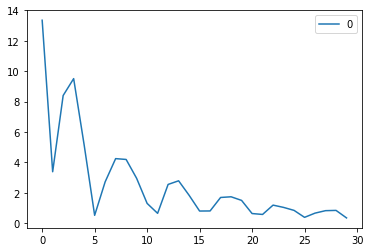

In [22]:
for i, losses in enumerate(losses_model):
    plt.figure()
    plt.plot(losses, label = str(i))
    plt.legend(loc="upper right")